Loading CSV: EnergyData_clean.csv
Loaded 140256 rows, aggregated to 1462 rows (D).

Training model for: MT_180
Starting RandomizedSearchCV for LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6132
[LightGBM] [Info] Number of data points in the train set: 877, number of used features: 38
[LightGBM] [Info] Start training from score 9.595103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

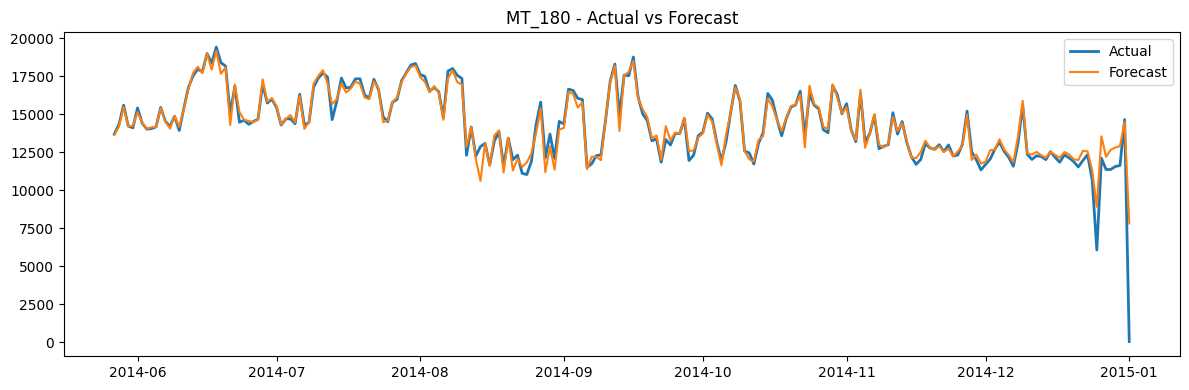


All models trained and saved to: lgbm_models

Example forecasting using model: MT_180
                forecast
date                    
2015-01-02   7515.496189
2015-01-03   9790.534326
2015-01-04  12576.594303
2015-01-05  13976.323029
2015-01-06  14636.109979


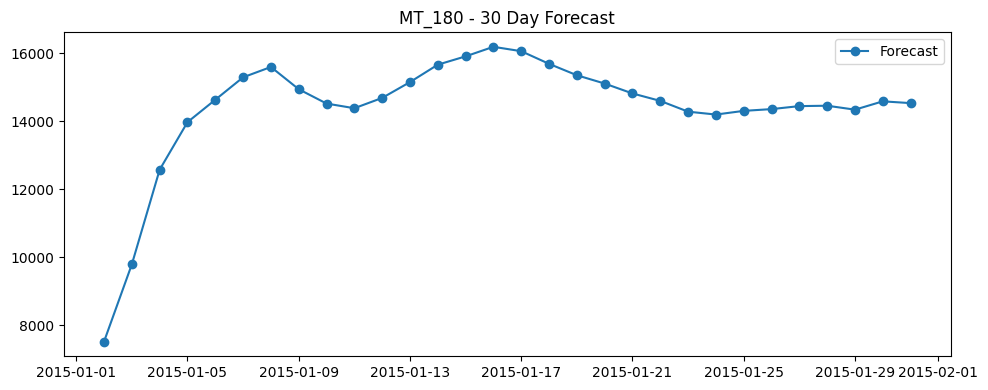

In [20]:
"""
Execution script for the LightGBM time-series pipeline.
Calls functions from lgbm_pipeline.py to run the complete workflow.
"""

import pandas as pd
import matplotlib.pyplot as plt
from lgbm_pipeline import load_and_aggregate, train_models, forecast_iterative

def main():
    # CONFIG - edit as needed
    FILE_PATH = "EnergyData_clean.csv"   # replace with your file path
    DATETIME_COL = "DateTime"
    AGG_FREQ = "D"                  # aggregate to daily
    AGG_METHOD = "sum"
    OUTPUT_DIR = "lgbm_models"
    USE_CLUSTERING = False          # True -> cluster meters and train one model per cluster
    N_CLUSTERS = 4
    TEST_SIZE = 0.2
    TUNE = True
    TUNE_ITER = 25

    # load & aggregate
    df_daily = load_and_aggregate(FILE_PATH, datetime_col=DATETIME_COL, freq=AGG_FREQ, agg_method=AGG_METHOD)

    # optional: select subset of meters
    meters = ["MT_180"]  # replace with your meter IDs
    # meters = None  # uncomment to use all meters

    # train models
    models_meta = train_models(df_daily,
                               meters=meters,
                               use_clustering=USE_CLUSTERING,
                               n_clusters=N_CLUSTERS,
                               test_size=TEST_SIZE,
                               tune=TUNE,
                               tune_iter=TUNE_ITER,
                               output_dir=OUTPUT_DIR)

    # example: forecast next 30 days for a given model name (pick one trained model)
    # choose first model saved:
    sample_model_name = list(models_meta.keys())[0]
    print("\nExample forecasting using model:", sample_model_name)
    model_obj = models_meta[sample_model_name]["model"]
    scaler_obj = models_meta[sample_model_name]["scaler"]
    feat_cols = models_meta[sample_model_name]["feature_columns"]
    
    # Use the test_df with its 'target' for historical lookups:
    hist_df = models_meta[sample_model_name]["test_df"][["target"]].copy()
    
    # forecast
    future = forecast_iterative(model_obj, scaler_obj, hist_df, feat_cols, steps=30)
    print(future.head())
    
    # plot forecast
    plt.figure(figsize=(10, 4))
    plt.plot(future.index, future["forecast"], marker="o", label="Forecast")
    plt.title(f"{sample_model_name} - 30 Day Forecast")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()